# Image Recognition with Caffe using ImageNet 

An image is recognised with the bundled CaffeNet model based on the network architecture of Krizhevsky et al. for ImageNet with 1000 categories. It is assumed that this notebook is in /deeplearning/notebooks/.

Imports.

In [105]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
import caffe
import os

Set up paths, scripts and models, mean pixel and labels file names.

In [106]:
# Make sure that caffe is on the python path:
caffe_root = '/opt/caffe/'  
sys.path.insert(0, caffe_root + 'python')
# model location
model_path  = 'models/bvlc_reference_caffenet/'
model_conf_name  = 'deploy.prototxt'
model_name = 'bvlc_reference_caffenet.caffemodel'
model_configuration = caffe_root + model_path + model_conf_name
model = caffe_root + model_path + model_name
# download script
download_script = '../scripts/download_model_binary.py'
# mean pixel file
mean_pixel_file  = caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy'
# ImageNet labels filename
imagenet_labels_filename = caffe_root + 'data/ilsvrc12/synset_words.txt'
# get labels script
get_labels = '!/opt/caffe/data/ilsvrc12/get_ilsvrc_aux.sh'

Download the pretrained CaffeNet model if not already available in the Caffe installation  (@<caffe_root>/models/bvlc_reference_caffenet). 

In [107]:
if not os.path.isfile(model):
    print("Downloading pre-trained CaffeNet model...")
    ! download_script model_path
else:
    print("The pre-trained CaffeNet model is already available!")

The pre-trained CaffeNet model is already available!


Set Caffe to CPU mode, load the net in the test phase for inference. 

In [108]:
mode = caffe.TEST
caffe.set_mode_cpu()
net = caffe.Net(model_configuration, model, mode)

Configure the input preprocessing.

In [109]:
batch_size =50
channels  = 3
gray_range = 255
image_size = 227

Input image location.

In [124]:
#nput_images_path = 'examples/images/'
#nput_fname = 'cat.jpg'
#nput_image_file = caffe_root + input_images_path + input_fname

input_images_path = '/deeplearning/Datasets/DemoImages/'
#input_fname = 'ostrich.jpg'
#input_fname = 'gun.jpg'
#input_fname = 'guncase.jpg'
input_fname = 'nlesc.jpg'
input_image_file = input_images_path + input_fname

In [125]:
# input preprocessing: 'data' is the name of the input blob == net.inputs[0]
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))
transformer.set_mean('data', np.load(mean_pixel_file).mean(1).mean(1)) # mean pixel
transformer.set_raw_scale('data', gray_range)  # the reference model operates on images in [0,255] range instead of [0,1]
transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB

Alghtough only one image will be classified, set up 50 to demonstrate batch processing.

In [126]:
net.blobs['data'].reshape(batch_size,channels,image_size,image_size)

Load the input image

In [127]:
if os.path.isfile(input_image_file):
    print("Loading input image ...")
    net.blobs['data'].data[...] = transformer.preprocess('data', caffe.io.load_image(input_image_file))
else:
    print("The specified input image cannot be found!")

Loading input image ...


What did the input look like?

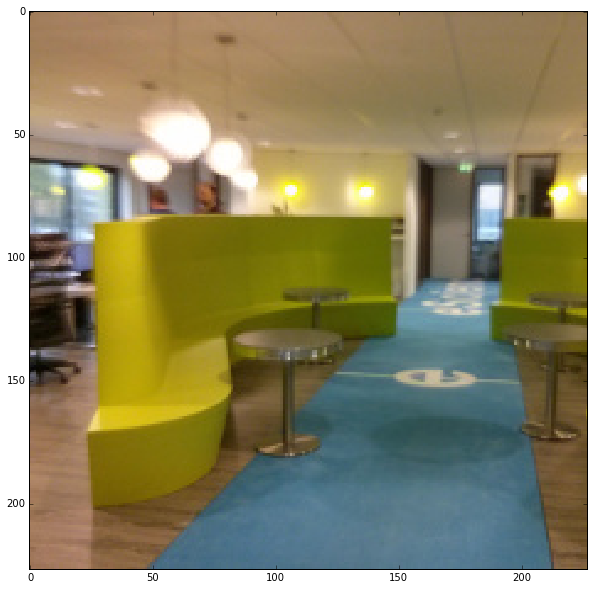

In [128]:
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

plt.imshow(transformer.deprocess('data', net.blobs['data'].data[0]))

Feed in the image (with some preprocessing) and classify with a forward pass.

In [129]:
print("Starting forward pass")
out = net.forward()
print("Predicted class is #{}.".format(out['prob'].argmax()))

Starting forward pass
Predicted class is #48736.


Was our classification correct?

In [130]:
# load labels
try:
    labels = np.loadtxt(imagenet_labels_filename, str, delimiter='\t')
except:
  #  get_labels
    !/opt/caffe/data/ilsvrc12/get_ilsvrc_aux.sh
    labels = np.loadtxt(imagenet_labels_filename, str, delimiter='\t')

# sort top k predictions from softmax output
top_k = net.blobs['prob'].data[0].flatten().argsort()[-1:-6:-1]
flattened = net.blobs['prob'].data[0].flatten()
flattened.sort()
print flattened[-1:-6:-1]
print labels[top_k]

[ 0.24835625  0.0674865   0.06630366  0.04250538  0.03846905]
['n03982430 pool table, billiard table, snooker table'
 'n04081281 restaurant, eating house, eating place, eatery'
 'n03452741 grand piano, grand' 'n04515003 upright, upright piano'
 'n03179701 desk']
